# Spherical cap

# Building on the previous notebook we now develop barycentric integrators for both 2D and 3D.

In this notebook the dual computations

In [2]:

from scipy.spatial import Delaunay
#import polyscope as ps


# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Imports and physical parameters
# std library

# plotting

# ddg imports
# Allow for relative imports from main library:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#from ddgclib._case1 import *
from ddgclib._complex import *
from ddgclib._capillary_rise import * #plot_surface#, curvature
from ddgclib._plotting import *

# Parameters for a water droplet in air at standard laboratory conditions
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
rho = 1000  # kg/m3, density
g = 9.81  # m/s2

# Parameters from EoS:
T_0 = 273.15 + 25  # K, initial tmeperature
P_0 = 101.325  # kPa, ambient pressure
#gamma = IAPWS(T_0)  # N/m, surface tension of water at 20 deg C
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
#rho_0 = eos(P=P_0, T=T_0)  # kg/m3, densi
rho = 1000  # kg/m3, density
g = 9.81  # m/s2

# Capillary rise parameters
r = 2.0  # m, radius of the tube
theta_p = 0 * np.pi/180.0  # Three phase contact angle
theta_p = 20 * np.pi/180.0  # Three phase contact angle
theta_p = 50 * np.pi/180.0  # Three phase contact angle

R = r / np.cos(theta_p)  # = R at theta = 0
# Exact values:
K_f = (1 / R) ** 2
H_f = 1 / R + 1 / R  # 2 / R


def compute_vd(HC, cdist =1e-10):
    """
    Computes the dual vertices of a primal vertex cache HC.V on
    each dim - 1 simplex.
    
    Currently only dim = 2, 3 is supported
    
    cdist: float, tolerance for where a unique dual vertex can exist
    
    """
    # Construct dual cache
    HC.Vd = VertexCacheField() 
    
    # Construct dual neighbour sets
    for v in HC.V:
        v.vd = set()
        
        
            
    #hcv = copy.copy(HC.V)        
    if HC.dim == 2:
        for v1 in HC.V:
            for v2 in v1.nn:
                
                # Find all v2.nn also connected to v1:
                v1nn_u_v2nn = v1.nn.intersection(v2.nn)
                for v3 in v1nn_u_v2nn:
                    if (v3 is v1):
                        continue
                    # TODO: Re-implement cache:
                    verts = np.zeros([3, HC.dim])
                    verts[0] = v1.x_a
                    verts[1] = v2.x_a
                    verts[2] = v3.x_a

                    # Compute the circumcentre:
                    #cd = circumcenter(verts)
                    # Compute the barycentre:
                    cd = np.mean(verts, axis=0)
                    # Note instead of below, could round off cd in general to say nearest 1e-12
                    # Check for uniqueness first (new, expensive, could 
                    # be improved by checking duals of neighbours only?):
                    for vd_i in HC.Vd:
                        dist = np.linalg.norm(vd_i.x_a - cd)
                        if dist < cdist:
                            cd = vd_i.x_a

                    vd = HC.Vd[tuple(cd)]
                    # Connect to all primal vertices
                    for v in [v1, v2, v3]:
                        v.vd.add(vd)
                        vd.nn.add(v)
    elif HC.dim ==3:
        for v1 in HC.V:
            for v2 in v1.nn:
                # Find all v2.nn also connected to v1:
                v1nn_u_v2nn = v1.nn.intersection(v2.nn)
                for v3 in v1nn_u_v2nn:
                    if (v3 is v1):
                        continue
                    v1nn_u_v2nn_u_v3nn = v1nn_u_v2nn.intersection(v3.nn)
                    #for v4 in v1nn_u_v2nn_u_v3nn:
                    for v4 in v1nn_u_v2nn_u_v3nn:
                        if (v4 is v1) or (v4 is v2):
                            continue
                        # TODO: Re-implement cache:
                        verts = np.zeros([HC.dim+1, HC.dim])
                        #print(verts)
                        verts[0] = v1.x_a
                        verts[1] = v2.x_a
                        verts[2] = v3.x_a
                        verts[3] = v4.x_a
                        print(verts)

                        # Compute the circumcentre:
                        #cd = circumcenter(verts)
                        # Compute the barycentre:
                        cd = np.mean(verts, axis=0)
                        # Note instead of below, could round off cd in general to say nearest 1e-12
                        # Check for uniqueness first (new, expensive, could 
                        # be improved by checking duals of neighbours only?):
                        for vd_i in HC.Vd:
                            dist = np.linalg.norm(vd_i.x_a - cd)
                            if dist < cdist:
                                cd = vd_i.x_a

                        vd = HC.Vd[tuple(cd)]
                        # Connect to all primal vertices
                        for v in [v1, v2, v3]:
                            v.vd.add(vd)
                            vd.nn.add(v)
    return HC  # self

# Find the Delaunay dual
def triang_dual(points, plot_delaunay=False):
    """
    Compute the Delaunay triangulation plus the dual points. Put into hyperct complex object.
    
    """
    dim = points.shape[1]
    tri = Delaunay(points)
    if plot_delaunay:  # Plot Delaunay complex
        import matplotlib.pyplot as plt
        plt.triplot(points[:,0], points[:,1], tri.simplices)
        plt.plot(points[:,0], points[:,1], 'o')
        plt.show()

    # Put Delaunay back into hyperct Complex object:
    HC = Complex(dim)
    for s in tri.simplices:
        for v1i in s:
            for v2i in s:
                if v1i is v2i:
                    continue
                else:
                    v1 = tuple(points[v1i])
                    v2 = tuple(points[v2i])
                    HC.V[v1].connect(HC.V[v2])

    compute_vd(HC, cdist =1e-10)
    return HC, tri





# Plot duals
def plot_dual_mesh_2D(HC, tri, points):
    """
    Plot the dual mesh and show edge connectivity. Blue is the primary mesh. Orange is the dual mesh.
    
    Note: Original points need to be fed that was used in the order to build `tri`
    """
    import matplotlib.pyplot as plt
    
    # Find the dual points
    dual_points = []
    for vd in HC.Vd:
        dual_points.append(vd.x_a)
    dual_points = np.array(dual_points)
    # Primal points 
    #points = []
    #for v in HC.V:
    #    points.append(v.x_a)
        
    #points = np.array(points)
    
    for v in HC.V:
        # "Connect duals":
        for v2 in v.nn:
            v1vdv2vd = v.vd.intersection(v2.vd)  # Cardinality always 1 or 2?
            if len(v1vdv2vd) == 1:
                continue
            v1vdv2vd = list(v1vdv2vd)
            x = [v1vdv2vd[0].x[0], v1vdv2vd[1].x[0]]
            y = [v1vdv2vd[0].x[1], v1vdv2vd[1].x[1]]
            plt.plot(x, y, color='orange')

        for vd in v.vd:
            x = [v.x[0], vd.x[0]]
            y = [v.x[1], vd.x[1]]
            plt.plot(x, y, '--', color='tab:green')
    plt.triplot(points[:,0], points[:,1], tri.simplices, color='tab:blue')
    plt.plot(points[:,0], points[:,1],  'o', color='tab:blue')
    plt.plot(dual_points[:,0], dual_points[:,1], 'o', color='tab:orange')
    plt.show()
    
def plot_dual_mesh_3D(HC, dual_points):
    """
    NOTE: The bug remains where it can only be plotted once, therefore rebuild the complex.
    """
    hcfig, hcaxes, _, _ = HC.plot_complex()
    hcaxes.scatter3D(dual_points[:, 0], dual_points[:, 1], dual_points[:, 2], color = "green")
    for v in HC.V:
        for vd in v.vd:
            x = [v.x[0], vd.x[0]]
            y = [v.x[1], vd.x[1]]
            z = [v.x[2], vd.x[2]]
            hcaxes.plot(x, y, zs=z, linestyle='--',  color='tab:green')
        #ax.plot([VecStart_x[i], VecEnd_x[i]], [VecStart_y[i],VecEnd_y[i]],zs=[VecStart_z[i],VecEnd_z[i]])

    plt.show()
    return

In [21]:
# Area computations
def d_area(vp1):
    """
    Compute the dual area of a vertex object vp1, which is the sum of the areas
    of the local dual triangles formed between vp1, its neighbouring vertices, 
    and their shared dual vertices.

    Parameters:
    -----------
    vp1 : object
        A vertex object containing the following attributes:
        - vp1.nn: a list of neighboring vertex objects
        - vp1.vd: a set of dual vertex objects
        - vp1.x_a: a numpy array representing the position of vp1

    Returns:
    --------
    darea : float
        The total dual area of the vertex object vp1
    """

    darea = 0  # Initialize total dual area to zero
    for vp2 in vp1.nn:  # Iterate over neighboring vertex objects
        # Find the shared dual vertices between vp1 and vp2
        vdnn = vp1.vd.intersection(vp2.vd)
        # Compute the midpoint between vp1 and vp2
        mp = (vp1.x_a + vp2.x_a) / 2
        # Compute the height of the dual triangle between vp1, vp2, and a dual vertex
        h = np.linalg.norm(mp - vp1.x_a)
        for vdi in vdnn:  # Iterate over shared dual vertices
            # Compute the base of the dual triangle between vp1, vp2, and vdi
            b = np.linalg.norm(vdi.x_a - mp)
            # Add the area of the dual triangle to the total dual area
            darea += 0.5 * b * h

    return darea

# DDG
def dP(vp1):
    """
    Compute the integrated pressure differential for vertex v     
    """
    dP_i = 0  # Total integrated Laplacian for each vertex
    for vp2 in vp1.nn:  # Iterate over neighboring vertex objects
      #  l_ij = np.linalg.norm(vp2.x_a - vp1.x_a)  # Not used here?
        e_dual = 0  # Initialize total edge dual length to zero
        # Find the shared dual vertices between vp1 and vp2
        vdnn = vp1.vd.intersection(vp2.vd)
        # Compute the midpoint between vp1 and vp2
        mp = (vp1.x_a + vp2.x_a) / 2
        # Compute the height of the dual triangle between vp1, vp2, and a dual vertex
        #h = np.linalg.norm(mp - vp1.x_a)
        #print(f'vdnn = {vdnn})
        for vdi in vdnn:  # Iterate over shared dual vertices
            # Compute the base of the dual triangle between vp1, vp2, and vdi
            b = np.linalg.norm(vdi.x_a - mp)  # dihedral weight
            # Add the area of the dual triangle to the total dual area
            e_dual += b
            if e_dual <= 1e-12:  # TODO: Set tolerance
                e_dual = 0
               
        #w_ij = l_ij/e_dual  # Weight
        #if (w_ij is np.inf) or (e_dual == 0):
        
            continue
        # Compute the area flux for the pressure differential:
        Area = e_dual* 1  # m2, Chosen height was 1 for our 2D test case
        # Compute the dual
        dP_ij = Area * (vp2.P - vp1.P)
        dP_i += dP_ij
        
    return dP_i

def du(vp1):
    """
    Compute the Laplacian of the velocity field for vertex v
    
    TODO: Compare this with the     
    """
    du_i = 0  # Total integrated Laplacian for each vertex
    for vp2 in vp1.nn:  # Iterate over neighboring vertex objects
        l_ij = np.linalg.norm(vp2.x_a - vp1.x_a)
        e_dual = 0  # Initialize total edge dual length to zero
        # Find the shared dual vertices between vp1 and vp2
        vdnn = vp1.vd.intersection(vp2.vd)
        # Compute the midpoint between vp1 and vp2
        mp = (vp1.x_a + vp2.x_a) / 2
        # Compute the height of the dual triangle between vp1, vp2, and a dual vertex
        #h = np.linalg.norm(mp - vp1.x_a)
        #print(f'vdnn = {vdnn})
        for vdi in vdnn:  # Iterate over shared dual vertices
            # Compute the base of the dual triangle between vp1, vp2, and vdi
            b = np.linalg.norm(vdi.x_a - mp)  # dihedral weight
            # Add the area of the dual triangle to the total dual area
            e_dual += b
            if e_dual <= 1e-12:  # TODO: Set tolerance
                e_dual = 0
               
        w_ij = l_ij/e_dual  # Weight
       # print('.')
       # print(f'l_ij = {l_ij}')
       # print(f'e_dual, len(vdnn)  = {e_dual, len(vdnn)}')
       # print(f'w_ij = { w_ij}')
       # print(f'w_ij is np.inf = {w_ij is np.inf}')
       # print(f'w_ij == np.inf = {w_ij == np.inf}')
        if (w_ij is np.inf) or (e_dual == 0):
            continue
        # Compute the dual
        du_ij = w_ij * (vp2.u - vp1.u)
        du_i += du_ij
        
    return du_i

def dudt(v):
    # Equal to the acceleration at a vertex (RHS of equation)
    dudt = -dP(v) + mu * du(v)
    dudt = dudt/v.m  # normalize by mass
    return dudt

In [22]:
# Test case traingulation
def incom_Poi(domain, refinements=2):
    """
    Compute the triangulate of a 2D incompressible Poiseuile flow
    """
    HC = Complex(2, domain)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()

    points = []
    for v in HC.V:
        points.append(v.x_a)
    points = np.array(points, dtype='float64')
    tri = Delaunay(points)
    return points

# 2D

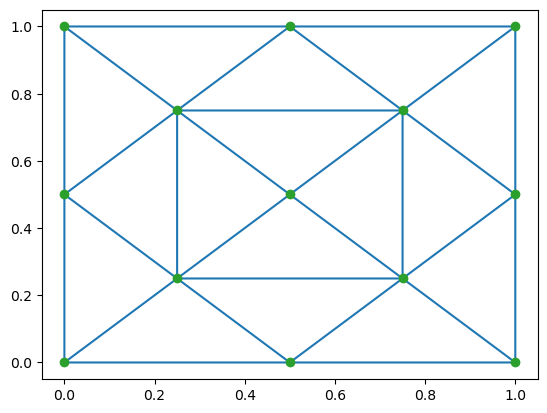

In [23]:
domain = [(0, 1),]*2
points = incom_Poi(domain, refinements=1)
HC, tri = triang_dual(points, plot_delaunay=True)
#HC.dim = 2
#HC = compute_vd(HC, cdist =1e-10)


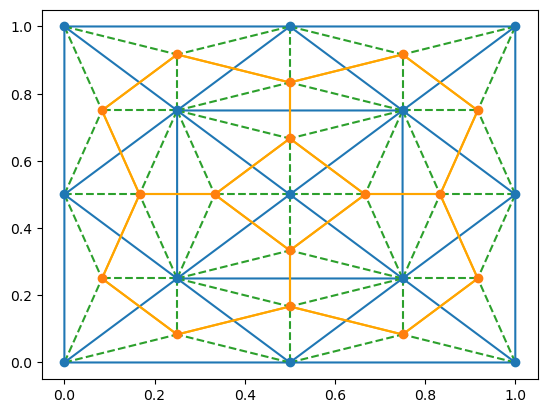

In [25]:
plot_dual_mesh_2D(HC, tri, points)

In [27]:
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)
dual_points = np.array(dual_points)

### Dual areas

Note that we only need the primal length $|e_{ij}|$ and the dual length/area $|e^*_{ij}|$

Alternatively we might also need the projection of the vector flow $f_i - f_j$ to be orthoganol to $e_{ij}$

In [29]:
v_i =  HC.V[(0.5, 0.5)]
v_j =  HC.V[(0.75, 0.75)]

In [32]:
e_ij_star = 0  # Initialize total dual area to zero
# Find the shared dual vertices between vp1 and vp2
vdnn = v_i.vd.intersection(v_j.vd)  # Should always be 2 for dim=2

vd1 = list(vdnn)[0]
vd2 = list(vdnn)[1]
e_ij_star = np.linalg.norm(vd1.x_a - vd2.x_a) 
e_ij_star

0.23570226039551578912

In [ ]:
# Wrap into function
def e_star(v_i, v_j, dim=2):
    """
    Compute the dual of the primary edge e_ij. It's needed to specify the dimension dim.
    
    return : e_ij_star
    """
    if dim = 2:
        e_ij_star = 0  # Initialize total dual area to zero
        # Find the shared dual vertices between vp1 and vp2
        vdnn = v_i.vd.intersection(v_j.vd)  # Should always be 2 for dim=2

        vd1 = list(vdnn)[0]
        vd2 = list(vdnn)[1]
        e_ij_star = np.linalg.norm(vd1.x_a - vd2.x_a) 

    if dim = 3:      
        pass  #TODO

    return e_ij_star


# 3 D


In [48]:
domain = [(0, 2),]*3
#symmetry = [0, 1, 1]
HC = Complex(3, domain=domain, symmetry=None)
HC.triangulate()
compute_vd(HC, cdist =1e-10)
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)

dual_points = np.array(dual_points, dtype='float64')
#dual_points

[[0. 0. 0.]
 [2. 0. 2.]
 [1. 1. 1.]
 [0. 0. 2.]]
[[0. 0. 0.]
 [2. 0. 2.]
 [1. 1. 1.]
 [2. 0. 0.]]
[[0. 0. 0.]
 [2. 0. 2.]
 [0. 0. 2.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [2. 0. 2.]
 [2. 0. 0.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [0. 2. 0.]
 [0. 2. 2.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [0. 2. 0.]
 [2. 2. 0.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [0. 2. 0.]
 [1. 1. 1.]
 [0. 2. 2.]]
[[0. 0. 0.]
 [0. 2. 0.]
 [1. 1. 1.]
 [2. 2. 0.]]
[[0. 0. 0.]
 [0. 0. 2.]
 [2. 0. 2.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [0. 0. 2.]
 [0. 2. 2.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [0. 0. 2.]
 [1. 1. 1.]
 [2. 0. 2.]]
[[0. 0. 0.]
 [0. 0. 2.]
 [1. 1. 1.]
 [0. 2. 2.]]
[[0. 0. 0.]
 [2. 0. 0.]
 [2. 0. 2.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [2. 0. 0.]
 [2. 2. 0.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [2. 0. 0.]
 [1. 1. 1.]
 [2. 0. 2.]]
[[0. 0. 0.]
 [2. 0. 0.]
 [1. 1. 1.]
 [2. 2. 0.]]
[[0. 0. 0.]
 [0. 2. 2.]
 [0. 2. 0.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [0. 2. 2.]
 [1. 1. 1.]
 [0. 2. 0.]]
[[0. 0. 0.]
 [0. 2. 2.]
 [1. 1. 1.]
 [0. 0. 2.]]
[[0. 0. 0.]
 [0. 2. 2.]
 [0. 0. 2.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [2. 2. 

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2957: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()


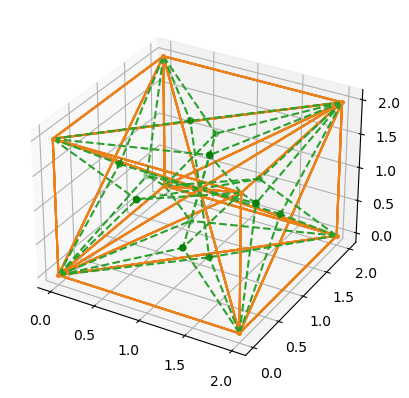

In [49]:
#hcaxes.scatter(dual_points)
   
plot_dual_mesh_3D(HC, dual_points)

In [51]:
for vd in HC.V:
    print(vd.x)

(0, 0, 0)
(2, 2, 2)
(2, 0, 0)
(0, 2, 0)
(2, 2, 0)
(0, 0, 2)
(2, 0, 2)
(0, 2, 2)
(1.0, 1.0, 1.0)


In [52]:
vi = HC.V[(1.0, 1.0, 1.0)]
vj = HC.V[(2, 2, 2)]

In [54]:
vdnn = vi.vd.intersection(vj.vd)
vdnn


{<ddgclib._vertex.VertexScalarField at 0x7f3aa8621bd0>,
 <ddgclib._vertex.VertexScalarField at 0x7f3aaa1411d0>}

In [56]:
import numpy as np

def area_of_polygon(points):
  """Calculates the area of a polygon in 3D space.

  Args:
    points: A numpy array of shape (n, 3), where each row represents a point in
      3D space.

  Returns:
    The area of the polygon.
  """

  # Calculate the cross product of each pair of adjacent edges.
  edges = points[1:] - points[:-1]
  cross_products = np.cross(edges[:-1], edges[1:])

  # Calculate the area of the triangle formed by each pair of adjacent edges and
  # the origin.
  triangle_areas = 0.5 * np.linalg.norm(cross_products, axis=1)

  # Sum the areas of all the triangles to get the total area of the polygon.
  return np.sum(triangle_areas)


# Example usage:

points = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0], [0, 0, 1]])
area = area_of_polygon(points)

print(area)

1.7071067811865475


In [57]:
local_dual_points = []
for vd in vdnn:
    local_dual_points.append(vd.x)
    
local_dual_points = np.array(local_dual_points)    
local_dual_points

array([[0.75, 1.25, 1.75],
       [1.75, 0.75, 1.25],
       [1.25, 1.75, 0.75],
       [1.75, 1.25, 0.75],
       [0.75, 1.75, 1.25],
       [1.25, 0.75, 1.75]])

In [58]:
area_of_polygon(local_dual_points)

1.7320508075688772

In [61]:
e_ij_star = 0  # Initialize total dual area to zero
vdnn = vi.vd.intersection(vj.vd)
 
local_dual_points = []
for vd in vdnn:
    local_dual_points.append(vd.x)
    
local_dual_points = np.array(local_dual_points) 
e_ij_star = area_of_polygon(local_dual_points)
e_ij_star

1.7320508075688772

# Extra test

In [63]:
domain = [(0, 0.5),]*3
#symmetry = [0, 1, 1]
HC = Complex(3, domain=domain, symmetry=None)
HC.triangulate()
compute_vd(HC, cdist =1e-10)
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)

dual_points = np.array(dual_points, dtype='float64')
#dual_points

[[0.   0.   0.  ]
 [0.5  0.   0.5 ]
 [0.   0.   0.5 ]
 [0.25 0.25 0.25]]
[[0.   0.   0.  ]
 [0.5  0.   0.5 ]
 [0.25 0.25 0.25]
 [0.   0.   0.5 ]]
[[0.   0.   0.  ]
 [0.5  0.   0.5 ]
 [0.25 0.25 0.25]
 [0.5  0.   0.  ]]
[[0.   0.   0.  ]
 [0.5  0.   0.5 ]
 [0.5  0.   0.  ]
 [0.25 0.25 0.25]]
[[0.   0.   0.  ]
 [0.   0.   0.5 ]
 [0.25 0.25 0.25]
 [0.   0.5  0.5 ]]
[[0.   0.   0.  ]
 [0.   0.   0.5 ]
 [0.25 0.25 0.25]
 [0.5  0.   0.5 ]]
[[0.   0.   0.  ]
 [0.   0.   0.5 ]
 [0.   0.5  0.5 ]
 [0.25 0.25 0.25]]
[[0.   0.   0.  ]
 [0.   0.   0.5 ]
 [0.5  0.   0.5 ]
 [0.25 0.25 0.25]]
[[0.   0.   0.  ]
 [0.5  0.5  0.  ]
 [0.25 0.25 0.25]
 [0.   0.5  0.  ]]
[[0.   0.   0.  ]
 [0.5  0.5  0.  ]
 [0.25 0.25 0.25]
 [0.5  0.   0.  ]]
[[0.   0.   0.  ]
 [0.5  0.5  0.  ]
 [0.   0.5  0.  ]
 [0.25 0.25 0.25]]
[[0.   0.   0.  ]
 [0.5  0.5  0.  ]
 [0.5  0.   0.  ]
 [0.25 0.25 0.25]]
[[0.   0.   0.  ]
 [0.   0.5  0.5 ]
 [0.   0.   0.5 ]
 [0.25 0.25 0.25]]
[[0.   0.   0.  ]
 [0.   0.5  0.5 ]
 [0.25 0.25 0.2

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2957: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()


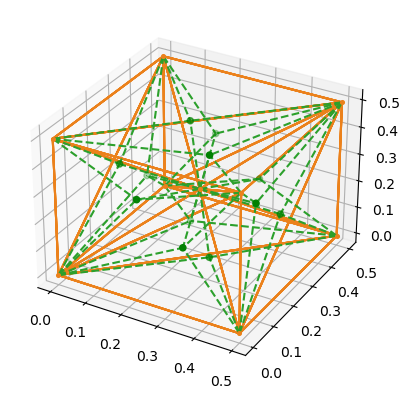

In [87]:
#hcaxes.scatter(dual_points)
   
plot_dual_mesh_3D(HC, dual_points)

In [85]:
vi = HC.V[(0.25, 0.25, 0.25)]

In [88]:
for vj in vi.nn:
    e_ij_star = 0  # Initialize total dual area to zero
    vdnn = vi.vd.intersection(vj.vd)
    print(len(list(vdnn)))
    local_dual_points = []
    for vd in vdnn:
        local_dual_points.append(vd.x)

    local_dual_points = np.array(local_dual_points) 
    e_ij_star = area_of_polygon(local_dual_points)
    print(e_ij_star)

4
0.038273277230987154
6
0.09472152853892296
4
0.038273277230987154
4
0.038273277230987154
4
0.038273277230987154
6
0.12178482240718669
4
0.038273277230987154
4
0.038273277230987154


In [70]:
# Bard AI code 

import numpy as np

def volume_of_geometric_object(points, extra_point):
  """Calculates the volume of a geometric object defined by adding an extra
  point away from the plane and connecting all points in the plane to it.

  Args:
    points: A numpy array of shape (n, 3), where each row represents a point in
      3D space.
    extra_point: A numpy array of shape (3,), representing the extra point away
      from the plane.

  Returns:
    The volume of the geometric object.
  """

  # Calculate the area of the base polygon.
  base_area = area_of_polygon(points)

  # Calculate the distance between the extra point and the base polygon.
  distance = np.linalg.norm(extra_point - np.mean(points, axis=0))

  # Calculate the volume of the geometric object.
  volume = base_area * distance

  return volume


# Example usage:

points = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0]])
extra_point = np.array([0, 0, 1])
volume = volume_of_geometric_object(points, extra_point)

print(volume)


1.224744871391589


# Test pyramid

In [71]:

# Create a pyramid with a known volume of pyramid_volume = 166.67
pyramid_points = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
                          [0.5, 0.5, 1]])

pyramid_points[:-1], pyramid_points[-1]

(array([[0., 0., 0.],
        [1., 0., 0.],
        [1., 1., 0.],
        [0., 1., 0.]]),
 array([0.5, 0.5, 1. ]))

In [76]:
# Create a pyramid with a known volume of pyramid_volume = 166.67
pyramid_points = np.array([[0, 0, 0], [10, 0, 0], [10, 10, 0], [0, 10, 0],
                          [5, 5, 5]])

volume_of_geometric_object(pyramid_points[:-1], pyramid_points[-1])

500.0

In [89]:

import numpy as np

def volume_of_geometric_object(points, extra_point):
  """Calculates the volume of a geometric object defined by adding an extra
  point away from the plane and connecting all points in the plane to it.

  Args:
    points: A numpy array of shape (n, 3), where each row represents a point in
      3D space.
    extra_point: A numpy array of shape (3,), representing the extra point away
      from the plane.

  Returns:
    The volume of the geometric object.
  """

  # Calculate the normal vector to the plane that contains the base polygon.
  normal_vector = np.cross(points[1] - points[0], points[2] - points[0])

  # Calculate the projection of the extra point onto the plane.
  projected_extra_point = extra_point - np.dot(extra_point - points[0], normal_vector) / np.linalg.norm(normal_vector)**2 * normal_vector

  # Calculate the distance between the extra point and its projection onto the plane.
  distance = np.linalg.norm(extra_point - projected_extra_point)

  # Calculate the area of the base polygon.
  base_area = area_of_polygon(points)

  # Calculate the volume of the geometric object.
  volume = 1/3 * base_area * distance

  return volume


In [90]:
# Create a pyramid with a known volume of pyramid_volume = 166.67
pyramid_points = np.array([[0, 0, 0], [10, 0, 0], [10, 10, 0], [0, 10, 0],
                          [5, 5, 5]])

volume_of_geometric_object(pyramid_points[:-1], pyramid_points[-1])

166.66666666666663

In [91]:
import numpy as np
#from volume_of_geometric_object import volume_of_geometric_object

# Create a pyramid with a known volume.
pyramid_points = np.array([[0, 0, 0], [10, 0, 0], [10, 10, 0], [0, 10, 0],
                          [5, 5, 5]])
pyramid_volume = 166.67

# Calculate the volume of the pyramid using your code.
pyramid_volume_calculated = volume_of_geometric_object(pyramid_points[:-1], pyramid_points[-1])

# Compare the calculated volume to the known volume.
pyramid_volume_calculated

166.66666666666663

# Area tests 

In [97]:
edges 

array([[ 1,  0],
       [ 0,  1],
       [-1,  0]])

In [96]:
# Calculate the cross product of each pair of adjacent edges.
points = square_points
edges = points[1:] - points[:-1]
cross_products = np.cross(edges[:-1], edges[1:])

# Calculate the area of the triangle formed by each pair of adjacent edges and
# the origin.
triangle_areas = 0.5 * np.linalg.norm(cross_products, axis=1)

# Sum the areas of all the triangles to get the total area of the polygon.
return np.sum(triangle_areas)

AxisError: axis 1 is out of bounds for array of dimension 1

In [99]:
"""Tests the area of a square."""

square_points = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0]])
expected_area = 1

calculated_area = area_of_polygon(square_points)
calculated_area 

1.0

In [100]:
"""Tests the area of a square."""

square_points = np.array([[0, 0, 0], [2, 0, 0], [2, 2, 0], [0, 2, 0]])
expected_area = 1

calculated_area = area_of_polygon(square_points)
calculated_area 

4.0

In [102]:
"""Tests the area of a triangle."""

triangle_points = np.array([[0, 0, 0], [1, 0, 0], [0.5, 1, 0]])
expected_area = 0.5

calculated_area = area_of_polygon(triangle_points)
calculated_area

0.5

In [ ]:
"""Tests the area of a polygon with holes."""

polygon_points = np.array([[0, 0, 0], [1, 0], [1, 1], [0, 1], [0.5, 0.5]])
hole_points = np.array([[0.25, 0.25], [0.75, 0.25], [0.75, 0.75], [0.25, 0.75]])
expected_area = 1 - 0.25

calculated_area = area_of_polygon(polygon_points, [hole_points])

In [93]:
import numpy as np
#from area_of_polygon import area_of_polygon

def test_area_of_square():
  """Tests the area of a square."""

  square_points = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])
  expected_area = 1

  calculated_area = area_of_polygon(square_points)

  assert calculated_area == expected_area

def test_area_of_triangle():
  """Tests the area of a triangle."""

  triangle_points = np.array([[0, 0], [1, 0], [0.5, 1]])
  expected_area = 0.5

  calculated_area = area_of_polygon(triangle_points)

  assert calculated_area == expected_area

def test_area_of_polygon_with_holes():
  """Tests the area of a polygon with holes."""

  polygon_points = np.array([[0, 0], [1, 0], [1, 1], [0, 1], [0.5, 0.5]])
  hole_points = np.array([[0.25, 0.25], [0.75, 0.25], [0.75, 0.75], [0.25, 0.75]])
  expected_area = 1 - 0.25

  calculated_area = area_of_polygon(polygon_points, [hole_points])

  assert calculated_area == expected_area

Finally we develop the 3D version of e_ij_star.

In [ ]:
domain = [(0, 2),]*3
#symmetry = [0, 1, 1]
HC = Complex(3, domain=domain, symmetry=None)
HC.triangulate()
compute_vd(HC, cdist =1e-10)
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)

dual_points = np.array(dual_points, dtype='float64')
#dual_points
vi = HC.V[(0.25, 0.25, 0.25)]

In [105]:
# Wrap into function
def e_star(v_i, v_j, dim=2):
    """
    Compute the dual of the primary edge e_ij. It's needed to specify the dimension dim.
    
    return : e_ij_star
    """
    if dim == 2:
        #e_ij_star = 0  # Initialize total dual area to zero
        # Find the shared dual vertices between vp1 and vp2
        vdnn = v_i.vd.intersection(v_j.vd)  # Should always be 2 for dim=2

        vd1 = list(vdnn)[0]
        vd2 = list(vdnn)[1]
        e_ij_star = np.linalg.norm(vd1.x_a - vd2.x_a) 

    elif dim == 3:      
        #e_ij_star = 0  # Initialize total dual area to zero
        vdnn = vi.vd.intersection(vj.vd)
        print(len(list(vdnn)))
        local_dual_points = []
        for vd in vdnn:
            local_dual_points.append(vd.x)

        local_dual_points = np.array(local_dual_points) 
        e_ij_star = area_of_polygon(local_dual_points)
    else:
        print("WARNING: Not implemented yet from dim > 3")

    return e_ij_star